# Investigating the DNN based electron ID

This study uses a flattened ntuple containing the DNN scores for individual electrons (along with other variables which I am ignoring for now). The input files from which these flat ntuples are produced are MiniAOD samples.

The DNN-ID for the electrons is based on the following scores of a multiclassifier.
```
'dnn_signal_Isolated'
'dnn_signal_nonIsolated'
'dnn_bkg_nonIsolated'
'dnn_bkg_Tau'
'dnn_bkg_Photon'
```
The MVA scores used in this study are the following.
```
'Fall17IsoV2Vals'
'Fall17IsoV2RawVals'
'RunIIIWinter22IsoV1Vals' *in case of Run3Winter23*
'RunIIIWinter22IsoV1RawVals' *in case of Run3Winter23*
```
These variables in the ntuple are produced using the following script. This ntuple maker runs in a CMSSW_13_0_8 environment which has the new RunIII MVA scores.

**ntuple maker:** <a href="https://github.com/cms-sw/cmssw/blob/master/RecoEgamma/ElectronIdentification/test/testElectronMVA_cfg.py">GitHub: cmssw/RecoEgamma/ElectronIdentification/test
/testElectronMVA_cfg.py</a><br>
(`testElectronMVARun3_cfg.py` in case of Run3Winter23)

The goal of this study is to compare these scores with the MVA scores.

---

# Setting up ...
The following cell contains all the global settings (like campaign name, branches, input and output directories etc.) The rest of the cells need not be modified.

In [1]:
import os, sys
import uproot
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import collections #for sorting dictionaries
from custom_func import *

########################
# INPUTS AND OUTPUTS
########################
campaign = 'Run3Summer22'
indir = 'inputs/'+campaign
outdir = 'plots/'+campaign
os.makedirs(outdir, exist_ok=True)

########################
#LISTS AND DICTIONARIES
########################
branches = [
    'ele_pt', 'ele_eta',
    'matchedToGenEle', #flag for deciding whether it is a signal or background electron 
    'dnn_signal_Isolated', 'dnn_signal_nonIsolated', 'dnn_bkg_nonIsolated', 'dnn_bkg_Tau', 'dnn_bkg_Photon', #DNN scores
    'Fall17IsoV2Vals', 'Fall17IsoV2RawVals', #MVA IDs from Run2
    #'RunIIIWinter22IsoV1Vals', 'RunIIIWinter22IsoV1RawVals' #MVA IDs from Run3
]

#DNN scores which are considered in plotting:
vardnn = ['score1', 'score2', 'score3', 'score4', 'score5']
#MVA scores which are considered in plotting:
varmva = ['MVA1', 'MVA2']

#renaming columns for my convenience:
rename = {
    'dnn_signal_Isolated':'score1',
    'dnn_signal_nonIsolated':'score2',
    'dnn_bkg_nonIsolated':'score3',
    'dnn_bkg_Tau':'score4',
    'dnn_bkg_Photon':'score5',
    'matchedToGenEle':'genmatch',
    'Fall17IsoV2Vals':'MVA1',
    'Fall17IsoV2RawVals':'MVA2',
    #'RunIIIWinter22IsoV1Vals':'MVA3',
    #'RunIIIWinter22IsoV1RawVals':'MVA4'
}

#Reversing this dictionary for later use
alias = {value: key for key, value in rename.items()}

sampledict = {
    "dy":{"name":"DrellYan", "color":"seagreen"},
    "qcd":{"name":"QCD", "color":"dodgerblue"},
    "gjet":{"name":"Gamma Jet", "color":"mediumorchid"},
    "taugun":{"name":"TauGun", "color":"orangered"},
}

print('Packages and functions loaded.')

Packages and functions loaded.


##### Reading input files

In [2]:
df = pd.DataFrame()

for name, val in sampledict.items():
    for filename in os.listdir(indir):
        if filename.startswith('ntuple_'+campaign+'_'+name):
            print(f'Reading file: {filename}')
            file=uproot.open(indir+'/'+filename)
            tree=file['ntuplizer/tree']
            df_temp=make_df(tree,branches,name)
            df=pd.concat([df, df_temp])
            
print('Reading successful!')
df[['ele_pt', 'ele_eta', 'matchedToGenEle', 'dnn_signal_Isolated', 'sample']]

Reading file: ntuple_Run3Summer22_dy.root
Reading file: ntuple_Run3Summer22_qcd.root
Reading file: ntuple_Run3Summer22_gjet.root
Reading file: ntuple_Run3Summer22_taugun.root
Reading successful!


,ele_pt,ele_eta,matchedToGenEle,dnn_signal_Isolated,sample
0,5.495893,2.044591,0,0.096490,dy
1,10.369920,-0.342826,2,0.675292,dy
2,9.652797,-1.871975,0,0.084962,dy
3,5.465273,-1.018275,3,0.400029,dy
4,12.036389,-2.063322,0,0.001662,dy
...,...,...,...,...,...
171106,13.619144,-1.004480,0,0.005307,taugun
171107,6.513440,-2.355769,0,0.025440,taugun
171108,25.561138,-0.215494,0,0.000068,taugun
171109,8.610294,0.143899,0,0.248473,taugun


##### Managing the dataframe and defining signal/background

The variable, `matchedToGenEle` contains integers, which mean the following things:

- 0: The candidate does not match to any gen-electron. (fake)
- 1: The candidate is a prompt, real electron; matches to gen-electron.
- 2: The candidate is a prompt, gen-matched electron decaying from a tau (not part of a jet).
- 3: The candidate is a real electron, but not isolated.

The signal electrons have `matchedToGenEle == 1 OR 2`<br>
The backgrounds have `matchedToGenEle == 0 OR 3`

In [3]:
df.rename(columns = rename, inplace = True)

#Normalizing all the scores from 0 to 1
for score, name in  rename.items():
    if score.startswith('dnn') or score=='matchedToGenEle' : break
    df=normalize_col(df, name)

#################################
# DEFINING SIGNAL AND BACKGROUND
#################################
sig_flag = (df['genmatch'] == 1) | (df['genmatch'] == 2)
bkg_flag = (df['genmatch'] == 0) | (df['genmatch'] == 3)

df.loc[sig_flag, 'truth'] = 1
df.loc[bkg_flag, 'truth'] = 0

#Randomizing rows:
df = df.sample(frac=1) #randomizing rows
df.reset_index(inplace=True, drop=True)

#Printing info:
txtfilepath = f'plots/{campaign}/statistics.txt'
if os.path.exists(txtfilepath): os.remove(txtfilepath)
txtfile = open(txtfilepath, 'a')
for name, val in sampledict.items():
    print_info(df, name, txtfile)

#randomly dropping backgrounds:
ndelete = 300000
if df[df['truth'] == 0].shape[0] > ndelete :
    indices = df[df['truth'] == 0].sample(n=ndelete, random_state=42).index
    df = df.drop(indices)

nsig = df[df['truth']==1].shape[0]
nbkg = df[df['truth']==0].shape[0]

stats = f'Total : sig = {nsig} ({nsig*100/df.shape[0]:.1f}%), bkg = {nbkg} ({nbkg*100/df.shape[0]:.1f}%)'
print(stats)
txtfile.write(stats)
txtfile.close()

df[['genmatch', 'MVA1', 'score1', 'sample', 'truth']]

Sample : dy; 	nCandidates = 76161; nsig = 60098 (78.9%), nbkg = 16063 (21.1%)
Sample : qcd; 	nCandidates = 61627; nsig = 0 (0.0%), nbkg = 61627 (100.0%)
Sample : gjet; 	nCandidates = 111633; nsig = 0 (0.0%), nbkg = 111633 (100.0%)
Sample : taugun; 	nCandidates = 171111; nsig = 0 (0.0%), nbkg = 171111 (100.0%)
Total : sig = 60098 (49.9%), bkg = 60434 (50.1%)


,genmatch,MVA1,score1,sample,truth
4,1,1.000000,0.935792,dy,1.0
6,0,-0.999346,0.035175,taugun,0.0
12,1,0.999999,0.942532,dy,1.0
15,3,0.999983,0.981317,taugun,0.0
17,3,1.000000,0.973126,gjet,0.0
...,...,...,...,...,...
420510,3,1.000000,0.981477,taugun,0.0
420512,0,-0.999370,0.000073,gjet,0.0
420522,3,0.999999,0.061882,gjet,0.0
420525,3,0.997169,0.569896,taugun,0.0


# Investigating the different samples:

Let's look at the following.
1. how the DNN scores look like for signal and background (overlayed)
2. how the DNN scores look like for candidates from different samples (overlayed)
3. how the MVA scores look like for signal and background (overlayed)
4. how the MVA scores look like for candidates from different samples (overlayed)

### DNN scores for signal and background:

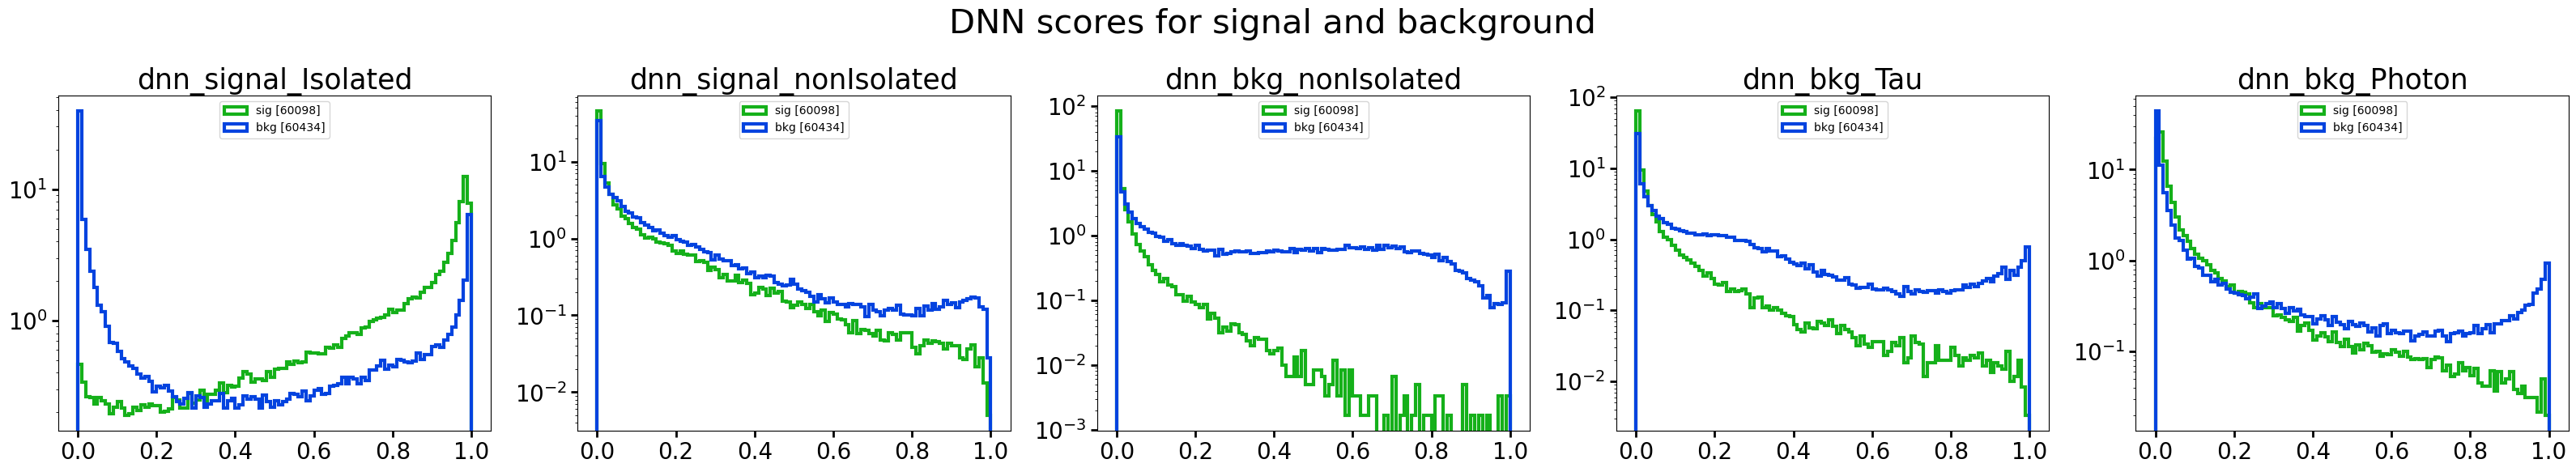

In [4]:
fig1, ax1 = plt.subplots(1,5,figsize=(40,6))
ax1 = ax1.flatten()
fig1.subplots_adjust(hspace=0.3)
plt.subplots_adjust(top=0.8)

bins_=np.arange(0, 1.01, 0.01)
fig1.suptitle('DNN scores for signal and background', fontsize=30) #Global title

nsig = df[df['truth']==1].shape[0]
nbkg = df[df['truth']==0].shape[0]

for i in range(len(vardnn)):
    ax1[i].hist(df[df['truth']==1][vardnn[i]], bins=bins_, histtype='step', linewidth = 3,
                color='xkcd:green',  label=f'sig [{nsig}]', density=True)
    ax1[i].hist(df[df['truth']==0][vardnn[i]], bins=bins_, histtype='step', linewidth = 3,
                color='xkcd:blue',  label=f'bkg [{nbkg}]', density=True)
    ax1[i].set_title(alias[vardnn[i]], fontsize=25)
    ax1[i].set_yscale('log')
    ax1[i].legend(loc='upper center')
    ax1[i].tick_params(axis='both', labelsize=20, width=2, length=6)
    
plt.savefig(outdir+'/all_dnn_overlayed.png', bbox_inches='tight', dpi=300)
plt.show()

### DNN scores for candidates from different samples:

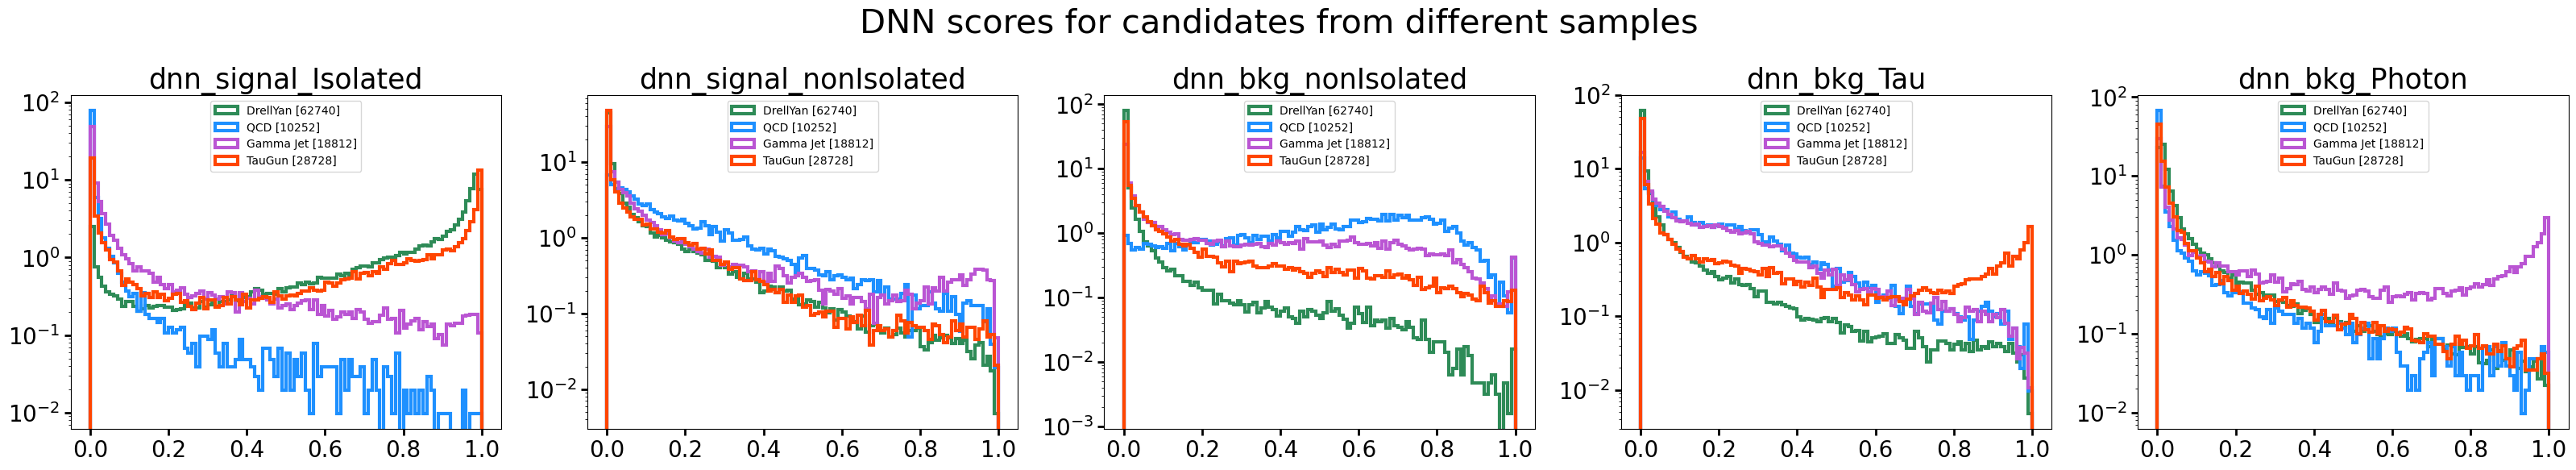

In [5]:
fig2, ax2 = plt.subplots(1,5,figsize=(40,6))
ax2 = ax2.flatten()
fig2.subplots_adjust(hspace=0.3)
plt.subplots_adjust(top=0.8)
fig2.suptitle('DNN scores for candidates from different samples', fontsize=30)
bins_=np.arange(0, 1.01, 0.01)

for i in range(len(vardnn)):
    for sample, val in sampledict.items():
        count = df[df['sample']==sample].shape[0]
        ax2[i].hist(df[df['sample']==sample][vardnn[i]], bins=bins_, histtype='step', linewidth = 3,
                color=val['color'],  label=f'{val["name"]} [{count}]', density=True)
    ax2[i].set_title(alias[vardnn[i]], fontsize=25)
    ax2[i].set_yscale('log')
    ax2[i].legend(loc='upper center')
    ax2[i].tick_params(axis='both', labelsize=20, width=2, length=6)
    
plt.savefig(outdir+'/all_dnn_samples.png', bbox_inches='tight', dpi=300)
plt.show()

### MVA scores:

# Comparing ROC curves